In [89]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [90]:
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)
df.head()

,Year,PPM
0,1959,315.98
1,1960,316.91
2,1961,317.64
3,1962,318.45
4,1963,318.99


In [91]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [92]:
TRAIN_SPLIT = 50

In [93]:
tf.random.set_seed(13)

In [94]:
uni_data = df['PPM']
uni_data.index = df['Year']
uni_data.head()

Year
1959    315.98
1960    316.91
1961    317.64
1962    318.45
1963    318.99
Name: PPM, dtype: float64

array([<AxesSubplot: xlabel='Year'>], dtype=object)

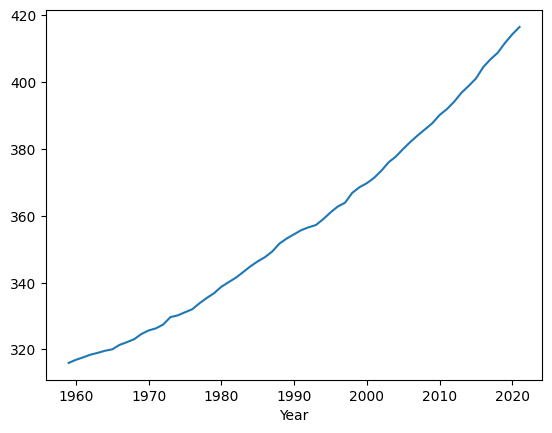

In [95]:
uni_data.plot(subplots=True)

In [96]:
uni_data = uni_data.values

In [97]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [98]:
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [99]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [100]:
x_train_uni

array([[[-1.42515846],
        [-1.38070829],
        [-1.3458173 ],
        [-1.30710264],
        [-1.28129286],
        [-1.25118145],
        [-1.23110718],
        [-1.16753866],
        [-1.128824  ],
        [-1.08724158],
        [-1.01220205],
        [-0.96153842],
        [-0.93094905],
        [-0.87646175],
        [-0.77035489],
        [-0.74597899],
        [-0.70105086],
        [-0.65803457],
        [-0.57152403],
        [-0.49648449]],

       [[-1.38070829],
        [-1.3458173 ],
        [-1.30710264],
        [-1.28129286],
        [-1.25118145],
        [-1.23110718],
        [-1.16753866],
        [-1.128824  ],
        [-1.08724158],
        [-1.01220205],
        [-0.96153842],
        [-0.93094905],
        [-0.87646175],
        [-0.77035489],
        [-0.74597899],
        [-0.70105086],
        [-0.65803457],
        [-0.57152403],
        [-0.49648449],
        [-0.42813638]],

       [[-1.3458173 ],
        [-1.30710264],
        [-1.28129286],
       

In [101]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.42515846]
 [-1.38070829]
 [-1.3458173 ]
 [-1.30710264]
 [-1.28129286]
 [-1.25118145]
 [-1.23110718]
 [-1.16753866]
 [-1.128824  ]
 [-1.08724158]
 [-1.01220205]
 [-0.96153842]
 [-0.93094905]
 [-0.87646175]
 [-0.77035489]
 [-0.74597899]
 [-0.70105086]
 [-0.65803457]
 [-0.57152403]
 [-0.49648449]]

 Target temperature to predict
-0.42813638376811486


In [102]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'D:\\coding\\python\\himcm-2022\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

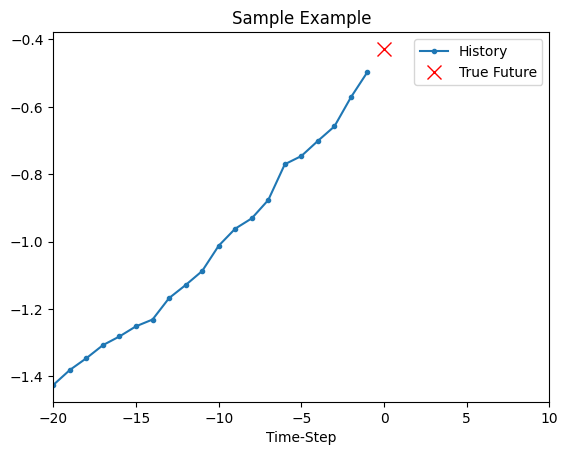

In [103]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from 'D:\\coding\\python\\himcm-2022\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

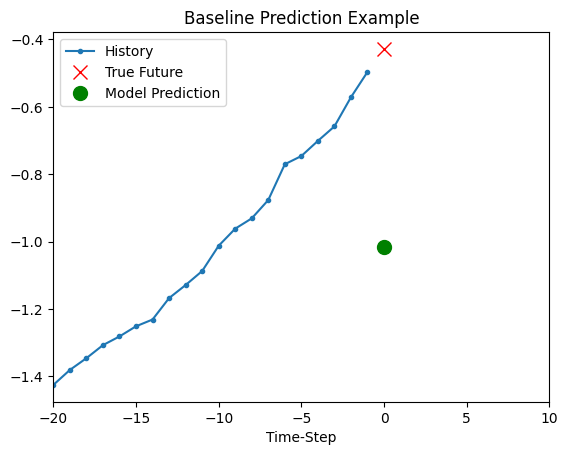

In [104]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [105]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [106]:
x_train_uni.shape[-2:]

(20, 1)

In [107]:
train_univariate

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [108]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 20)                1760      
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [109]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

In [110]:
val_univariate.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [113]:
val_univariate

<RepeatDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [111]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
198/200 [============================>.] - ETA: 0s - loss: 0.1067WARNING:tensorflow:Model was constructed with shape (None, 20, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='lstm_7_input'), name='lstm_7_input', description="created by layer 'lstm_7_input'"), but it was called on an input with incompatible shape (None,).


ValueError: in user code:

    File "D:\coding\python\himcm-2022\venv\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "D:\coding\python\himcm-2022\venv\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\coding\python\himcm-2022\venv\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "D:\coding\python\himcm-2022\venv\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "D:\coding\python\himcm-2022\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\coding\python\himcm-2022\venv\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_7" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_7" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float64)
      • training=False
      • mask=None


In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()